 ## <center>Practicing Machine Learning</center>
### <center>Simple Regression Analysis </center>
#### <center>California Housing Price Prediction </center>
##### <center> Recommended Source: <a href="https://www.amazon.com/-/es/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_fkmr1_1?__mk_es_US=%C3%85M%C3%85%C5%BD%C3%95%C3%91&crid=2Y7BISU0SQYCV&keywords=hand+son+machine+learning+tensorflow+keras&qid=1664596219&qu=eyJxc2MiOiIwLjkzIiwicXNhIjoiMC4wMCIsInFzcCI6IjAuMDAifQ%3D%3D&sprefix=hand+son+machine+learning+tensorflow+keras%2Caps%2C105&sr=8-1-fkmr1">Link</a></center>


### Loading required imports

In [250]:
import pandas as pd
import os
import tarfile
import urllib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt

### Getting the Housing Dataset for California

In [251]:
DL_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DL_ROOT + "datasets/housing/housing.tgz"

In [252]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

#### Basic Exploration
After loading the data it's a good practice to review the data and gain insights. The first part of this process is getting a description of the data, so we can know what we are working with.

In [253]:
housing_data = pd.read_csv(os.path.join(HOUSING_PATH, "housing.csv"))
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [254]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [255]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Now that we have seen the data description we know the following:
<li>We have 9 continuous variables and one categorical</li>
<li>we have 5 categories in the categorical variable 'ocean_proximity'</li>
<li>'total_bedrooms' is missing values since the total count of items is 20640 and we got 20433</li>
<li>there is a huge difference between max and 75% percentile of 'median_income' meaning that 75% of owners make less than 474000 or less per year and there are some outliers that take the max value to over 1,500,000</li>
<li>there is a huge difference between max and 75% percentile of 'median_house_value' meaning that 75% of houses cost 264,725 or less and there are outliers that take the max value over 500001</li>


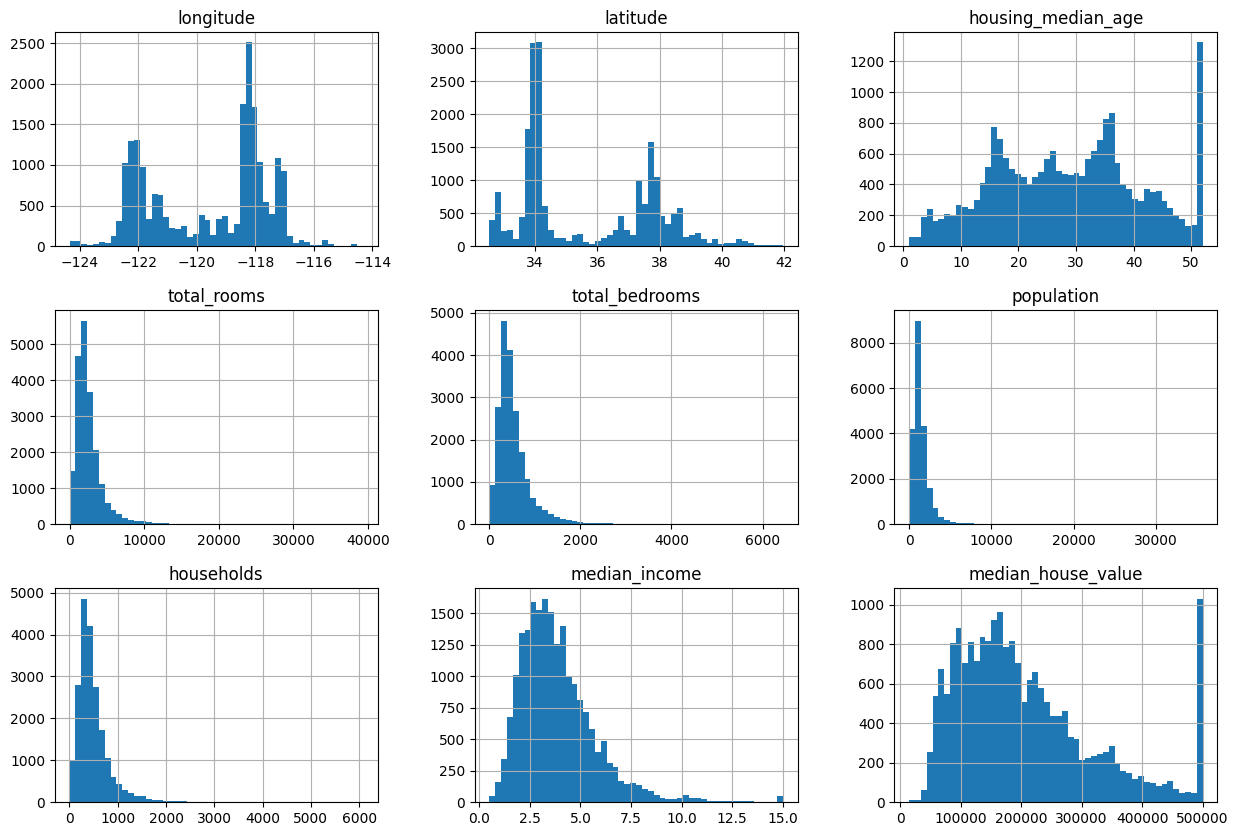

In [256]:
housing_data.hist(bins=50, figsize=(15,10))
plt.show()

After reviewing the data distribution I noticed that the 'median_house_value' was probably limited by whoever took this dataset meaning that they capped it at 500,000 usd so all houses above that price were set at 500,000 usd. Not the best thing to do in this case you can either contact whoever did this, or maybe even discard this since it will skew our models judging by the seen frequency of the value.

In [257]:
housing_data = housing_data[housing_data['median_house_value']<500000].reset_index(0)

### Data Preparation

We have seen all we can from the data now let's see what we can do with it to make it better. In this phase we have to work on the data depending on what we saw in the data to prepare it for training and evaluating different models.

### Data Separation Techniques
You might be thinking "Why are we separating the data right now?. Without going deeper?? Why not use all the data for my EDA???" the answer is to avoid finding patterns shown when seeing all the data this is called "data snooping bias" and will likely lead to <a href=https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/>overfitting</a>,

 The first data separation technique to be displayed is the standard 'train_test_split function' in our scikit-learn distribution. This method is generally good in dividing data for training and testing using random sampling.

3    0.361560
2    0.332294
4    0.177949
5    0.087352
1    0.040845
Name: income_cat, dtype: float64

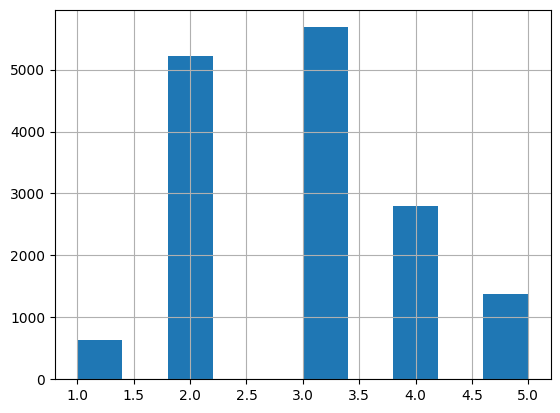

In [258]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=1989)
train_set['income_cat'] = pd.cut(train_set['median_income'],bins=[0,1.5,3.,4.5,6., np.inf],labels=[1,2,3,4,5])
train_set['income_cat'].hist()
standard_random_splitting = train_set['income_cat'].value_counts()/ len(train_set)
standard_random_splitting

In [259]:
len(test_set)

3930

The only downside is that this method relies solely on random sampling but what happens when data is inherently categorized in subgroups, this method would be heavily biased, eg. a dataset with 55% men and 45% women will be skewed.

Assuming the median income is a very important attribute to predict median housing prices. It is important that we ensure that the test set is representative of income categories. For this we will need to play around with the bin # factor in the pandas.cut() function which creates categories based on a number of bins. These bins need to represent the data so keep that in mind when you check the data.

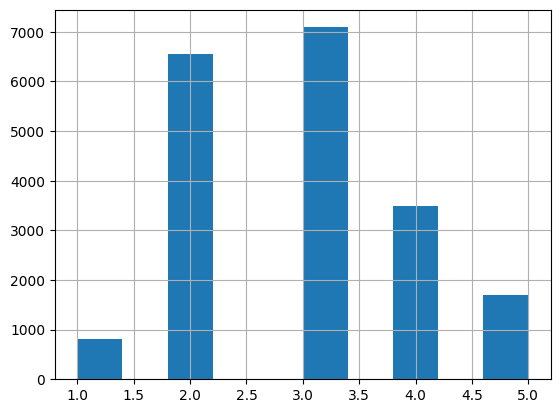

In [260]:
housing_data['income_cat'] = pd.cut(housing_data['median_income'],bins=[0,1.5,3.,4.5,6., np.inf],labels=[1,2,3,4,5])
housing_data['income_cat'].hist()
original_sub_categories = housing_data['income_cat'].value_counts()/ len(housing_data)

To take into account these subgroups we will leverage the 'Stratified_Shuffle_Split()' function that allows us to take into account the proportion or stratification in these subgroups, in other words it is a stratified sampling method.

In [261]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1989)

After splitting the data we define our new stratified train and test sets as seen below.

In [262]:
for train_index, test_index in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

Now lets take a look at the error between our stratified training set and our original proportions by running the following code

In [263]:
splitting_error = pd.DataFrame(original_sub_categories - strat_test_set['income_cat'].value_counts()/ len(strat_test_set)).abs()*100
splitting_error['Original Distribution'] = original_sub_categories
splitting_error['Stratified Distribution'] = strat_test_set['income_cat'].value_counts()/ len(strat_test_set)
splitting_error['Standard Splitter Distribution'] = standard_random_splitting
splitting_error['income_cat'] = splitting_error['income_cat']/original_sub_categories
splitting_error['Standard Splitter Error %'] = ((original_sub_categories - standard_random_splitting)/original_sub_categories).abs()*100
splitting_error = splitting_error.rename(columns={'income_cat': 'Stratified Splitting Error %'})
splitting_error[['Original Distribution',
                 'Stratified Distribution',
                 'Standard Splitter Distribution',
                 'Standard Splitter Error %',
                 'Stratified Splitting Error %']]

,Original Distribution,Stratified Distribution,Standard Splitter Distribution,Standard Splitter Error %,Stratified Splitting Error %
3,0.360851,0.360814,0.361560,0.196485,0.010178
2,0.333215,0.333333,0.332294,0.276216,0.035640
4,0.177932,0.177863,0.177949,0.009696,0.038779
5,0.086625,0.086514,0.087352,0.839816,0.127675
1,0.041378,0.041476,0.040845,1.289001,0.235799


We can notice that indeed stratified splitting helps in terms of preserving the data as unbiased as possible. Let's look at the histogram to see if it mantained the same distribution as the original dataset.

<AxesSubplot: >

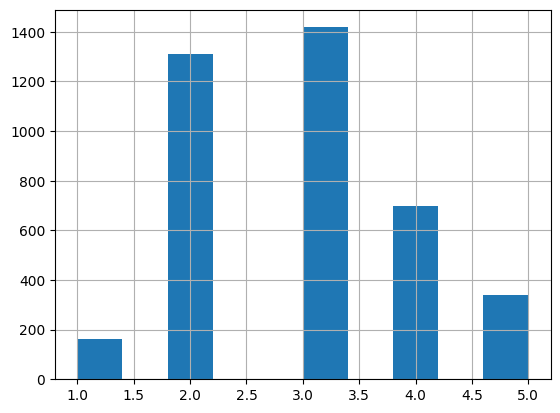

In [264]:
strat_test_set['income_cat'].hist()

Now we can rest assured that we have our data the way it was intended and we can now drop the categorical feature we created for our stratified split.

In [265]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Visualization of our data
let's make a copy of our stratified data in order to start plotting the geographical data.

In [266]:
housing = strat_train_set.copy()

We now proceed to plot our longitude and latitude using 'pandas.plot()' function.

C:\Users\Usuario1\anaconda3\envs\Machine Learning Topics Explanation\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

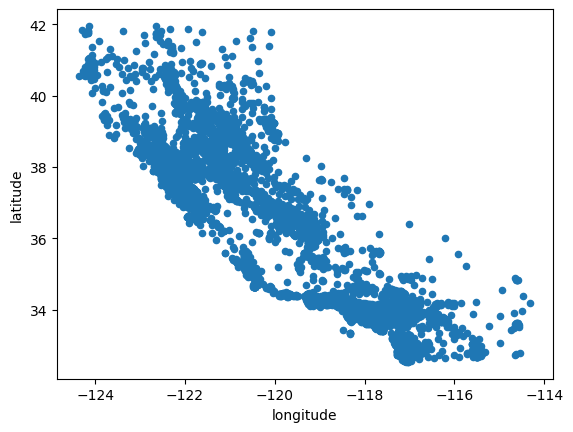

In [267]:
housing.plot(kind='scatter', x='longitude', y='latitude')

We can see that the data is shown and it gives us a somewhat outline of the california coast. No other information can be extracted at plain site so let's proceed to tinker with our 'pandas.plot()' function in order to show the density of points in a much more practical way using the alpha parameter set to 0.1.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

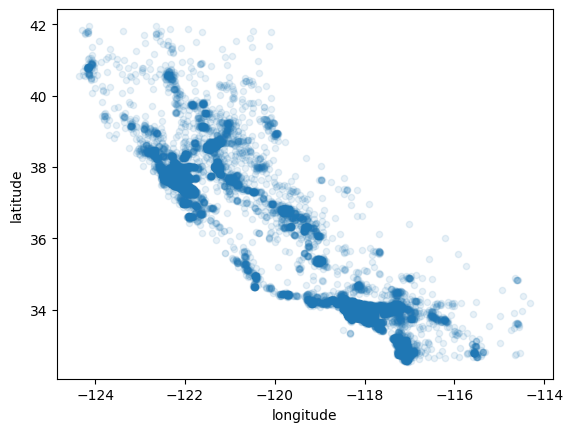

In [268]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now lets look at the housing prices using again the 'pandas.plot()' function. This time we incorporate the radius of each circle using the parameter 's' these circle represent the district's population and the parameter 'c' which is the color that represents the price. We then use the cmap color called jet for the parameter 'cmap'.

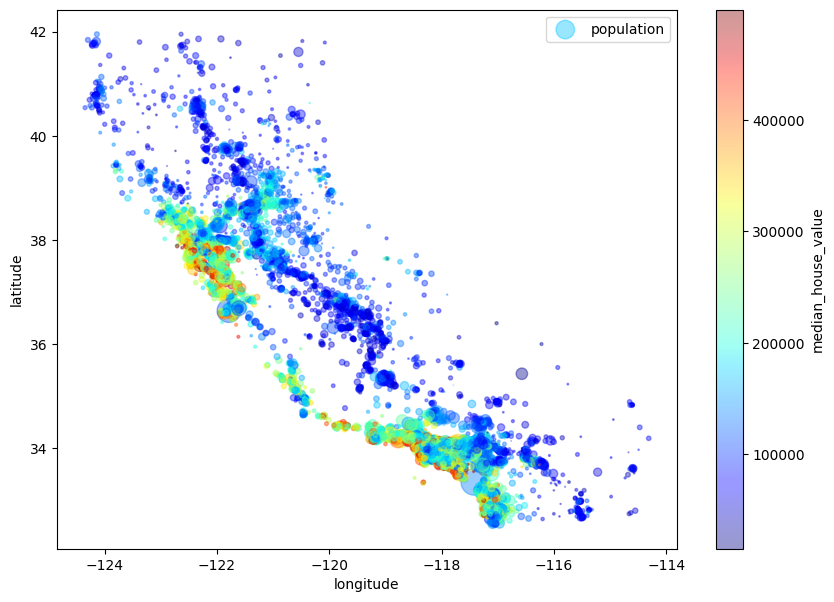

In [269]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7), c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

The resulting image showcases the fact that the housing prices are very much related to the location (e.g., near the ocean) and the population density. A clustering algorithm might be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. Although in northern california we can see that the coastal districts are not too high, so it is no simple rule to define for everyone.

Next we should review correlations for our attributes to see what other things we can use for our model.

In [270]:
corr_matrix = housing.corr()

In [271]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.650120
total_rooms           0.153225
households            0.103477
total_bedrooms        0.083306
index                 0.066936
housing_median_age    0.060428
population            0.020185
longitude            -0.043466
latitude             -0.152561
Name: median_house_value, dtype: float64

For a correlation to be strong the value requires to be near -1 or 1, the closer the value is to 0 means that that variable probably does not influence our dependent variable.

### Feature Engineering

Now that we saw we had multiple variables that don't influence our dependent variable we should look to try to create new ones that do influence from the variables we have. For this, we look into 'rooms_per_household', 'bedrooms_per_room' and 'population_per_household'

In [272]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']
# resetting to show better way of doing this
housing = strat_train_set.copy()

Another way  of doing this that is much better is to create a custom transformer as seen below, this is much better since we can use this later on to automatically apply the values to our test set.


In [273]:
from sklearn.base import BaseEstimator, TransformerMixin
# these are index values for the columns in our dataframe
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttibutesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [274]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.650120
total_rooms           0.153225
households            0.103477
total_bedrooms        0.083306
index                 0.066936
housing_median_age    0.060428
population            0.020185
longitude            -0.043466
latitude             -0.152561
Name: median_house_value, dtype: float64

Now we have 3 new variables that have somewhat correlation in regards to our dependent variable.

### Data Preparation

The data preparation step handles our missing data issue. For this, I chose to use the SimpleImputer() class from the scikit-learn package using as a strategy the 'median' to replace the missing values.

In [275]:
imputer = SimpleImputer(strategy="median")
# we drop ocean_proximity column to avoid imputation errors
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
# After fitting the imputer we can proceed to transforming our data followed by defining a new dataframe with the imputed data.
x= imputer.transform(housing_num)
housing_transformed = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

Another way of doing Imputation is using the 'pandas.fillna()' function to fill all missing data with the median

In [276]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace=True)

Now we need to convert the "ocean_proximity" column into something usable, for this we use the standard 'One Hot Encoder' class in the scikit-learn package for it to convert object data into numerical categories.

In [277]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[["ocean_proximity"]])

Lastly we can create a pipeline that applies all techniques above to our data automatically, this is helpful in real world projects and when automating machine learning workflows. For this we create a 'Pipeline()' object which will encapsulate all processes needed to transform the data and prepare it for our machine learning model.

In [278]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribute_adder', CombinedAttibutesAdder()),
    ('std_scaler',StandardScaler()),

])
num_pipeline.fit_transform(housing_num)


num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

### Model Selection

Now that we have seen the data and prepared it we can now proceed to the fun part of ML which is training machine learning models. For this I usually like to train multiple models and see which model performed the best given the provided data. This process is iterative following these steps:
<ol type="1">
<li>Select a models to train</li>
<li>Train the models</li>
<li>Select a performance metric(we will be using the Root Mean Squared Error)</li>
<li>Compare models performance(metric)</li>
<li>Tune all hyperparameters</li>
<li>Select best performing model</li>
</ol>

The first model I selected to use is the linear regression model which is a very basic way of predicting prices, keep in mind that if this model really under performs you might have data that cannot be represented as linear.

Scikit-learn's implementation of linear regression hast a function called 'fit()' this function is our way of training our model.

In [279]:
housing_labels = strat_train_set['median_house_value'].copy()
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Now that our model has been trained we should use our prepared dataset to predict values of unseen data

In [280]:
some_data = test_set.sample(frac=1).iloc[:5]
some_labels = some_data['median_house_value']
some_data_prepared = full_pipeline.transform(some_data)
predictions = lin_reg.predict(some_data_prepared)
print('first prediction ', predictions.tolist()[0])
print('real value', some_labels.iloc[0])

first prediction  239900.00000000015
real value 239900.0


Outstanding! it seems our model is able to predict fairly well unseen houses!. Let's check what our training RMSE is. Remember that the closer to 0 the <a href=https://gisgeography.com/root-mean-square-error-rmse-gis/>RMSE</a> is indicates a better model performance.

In [281]:
predictions = lin_reg.predict(housing_prepared)
mse = mean_squared_error(housing_labels, predictions)

rmse = np.sqrt(mse)

print("error", rmse)

error 9.516449940505048e-11


Awesome!, we had good results since our error value is very close to 0, maybe too close to my liking!. This might be what I mentioned before <a href=https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/>overfitting</a> and our model might not perform well over time with new data. Now let's look at another example and see if this happens on other models.

In [282]:
tree_reg = DecisionTreeRegressor(
)
tree_reg.fit(housing_prepared, strat_train_set['median_house_value'].copy())
predictions = tree_reg.predict(housing_prepared)
rmse = np.sqrt(mean_squared_error(strat_train_set['median_house_value'].copy(), predictions))
rmse

0.0

Suspicion confirmed! this time we were able to have an "errorless" model but is this possible?. In practice, it is, and how can I fix this?. There are 3 main ways to fight "overfitting" when training with your data
<ol type="1">
    <li><a href=https://www.mygreatlearning.com/blog/cross-validation/>Cross Validation</a></li>
    <li><a href=https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a>Regularization </a> (open link in private session for you to be able to see it without having to register to medium)</li>
    <li>Choosing simple models for our data normally helps</li>
</ol>



Let's look at our friend <a href=https://www.mygreatlearning.com/blog/cross-validation/>Cross Validation</a>, this model breaks the data into "bins" and trains models on each bin to find the best performing model. for this we use the 'cross_val_score()' function from scikit-learn with our tree_reg this process takes a long time but trust me it will make a difference.

In [283]:

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

Now I'm ready to calculate the RMSE of our new model by just applying the squared root to our scores result.

In [284]:
tree_rmse = np.sqrt(-scores)
tree_rmse

array([100.38095376, 213.39524934, 165.88876987, 119.34405115,
       218.74613773, 107.98289375, 241.08137556,  90.48216897,
       112.29337769, 108.00252549])

In [285]:
def display_scores(scores):
    print("scores ", scores)
    print("mean ", scores.mean())
    print("STD", scores.std())
display_scores(tree_rmse)

scores  [100.38095376 213.39524934 165.88876987 119.34405115 218.74613773
 107.98289375 241.08137556  90.48216897 112.29337769 108.00252549]
mean  147.75975033253914
STD 53.979899498525405


Now we have done the cross validation exercise to fix Overfitting, let's look at the same problem but with another type of model called ensemble model, in this example we will be using Random Forest Regressor as our third and last model. For this model I will be using some "Fine tuning" in order to have great results comming from our cross validation.

The fine tuning process will be done using <a href=https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html>Grid Search</a> from the scikit_learn distribution.

In [286]:
param_grid = [
    {
        'n_estimators': [3, 10, 30],
        "max_features": [2, 4, 6, 8],
    },
    {
        "bootstrap": [False],
        "n_estimators": [3, 10],
        "max_features": [2, 3, 4]
    }
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=7, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=7, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [287]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [288]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

Now that we have our best estimator lets print the cross validation scores for each model and see why our max_features=8 and n_estimators=30 model is best

In [289]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score),params)

32630.656775656676 {'max_features': 2, 'n_estimators': 3}
23195.10637444403 {'max_features': 2, 'n_estimators': 10}
20624.891329834856 {'max_features': 2, 'n_estimators': 30}
18916.889307068162 {'max_features': 4, 'n_estimators': 3}
11653.945224218083 {'max_features': 4, 'n_estimators': 10}
10331.428553854576 {'max_features': 4, 'n_estimators': 30}
10624.443339669439 {'max_features': 6, 'n_estimators': 3}
7379.884641619971 {'max_features': 6, 'n_estimators': 10}
5562.35706674768 {'max_features': 6, 'n_estimators': 30}
6919.008396573253 {'max_features': 8, 'n_estimators': 3}
4271.963049963873 {'max_features': 8, 'n_estimators': 10}
3136.510441340623 {'max_features': 8, 'n_estimators': 30}
30015.52614253462 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
22622.740640341064 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
20868.97639344623 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
14936.548860182702 {'bootstrap': False, 'max_features': 3, 'n_estimato

#### Analyze best models and their errors

In [290]:
feature_importances = grid_search.best_estimator_

## Trying model on Test Data
Again we go through this process and check how Random Forest Regressor did against our Linear Regressor. Let's evaluate our model as is with unseen data

In [291]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.copy()#.drop("median_house_value", axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

3094.4575957039447

Why did this model fail in comparison to our linear regressor?. Well some problems do not require complexity meaning that the simplicity of our linear regression worked out in its favor.

What can we do to make it compete? Personally there are a few things that might do the trick:
<ol type="1">
    <li>Replace GridSearchCV with <a href=https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV>Randomized Search</a></li>
    <li>Use feature importance values to eliminate or drop columns that are not needed, this will make the model simpler</li>
</ol>

### Analyzing the result with T test

Sometimes we have to take things into account imagine we have a model that performs well for 87% of predictions and our newly trained model performs only 0.1% better, should we launch into production?. For this it is better to have an idea of how precise this estimate is. For this you can compute a 95% confidence interval for the generalization error using 'scipy.stats.t.interval()'

In [292]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(
    stats.t.interval(
    confidence,
    len(
            squared_errors
        ),
    loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)
    )
)

array([2652.97316372, 3480.38345816])

Now that we have our interval. The score was 3094.46 RMSE which does fall in our confidence interval(2652.97, 3480.38), this means our model is good to go!.